In [85]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

In [86]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

### Metrics used (PSNR & MSE &SSIM)

Specifically, MSE loss is used in SRCNN model while PSNR loss is used in EDSR model

In [87]:
# peak signal-to-noise ratio loss (PSNR)
def psnr(target, ref):

    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = (ref_data - target_data).flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# mean squared error loss (MSE)
def mse(target, ref):
    
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)   
    err /= float(target.shape[0] * target.shape[1])
    
    return err

def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

### Prepare Data by Downsampling factor of 2 and upsampling factor of 2 

The dataset we used are T91, Set5 and Set14 with only high-resolution images. 

Create the low-resolution images by ourselves. 

In this case, downsample the ground-truth images by a scale factor of 2, which becomes a low-resolution image, and then upsample this image by a scale factor of  2 in order to let those low-resolution images match the size of our output. Notice that both of the operations are using the bicubic interpolation. 

In [88]:
def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        if file != '.ipynb_checkpoints':
            # open the file
            img = cv2.imread(path + '/' + file)

            # find old and new image dimensions
            h, w, _ = img.shape
            new_height = h / factor
            new_width = w / factor
            
            # resize the image - down
            img = cv2.resize(img, (int(new_width), int(new_height)), interpolation = cv2.INTER_LINEAR)
            # resize the image - up bicubic 
            img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
            
            # save the image
            cv2.imwrite('images/{}'.format(file), img)

In [90]:
prepare_images('source/', 2)

### Calculate the loss between the LR input and corresponding ground truth images

In [91]:
for file in os.listdir('images/'):
    
    if file != '.ipynb_checkpoints':
    
        # open target and reference images
        target = cv2.imread('images/{}'.format(file))
        ref = cv2.imread('source/{}'.format(file))
        
        # calculate score
        scores = compare_images(target, ref)
        
        # print all three scores with new line characters (\n) 
        print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

/home/d1guan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


monarch.bmp
PSNR: 30.196242365288896
MSE: 186.45643615722656
SSIM: 0.9439574293434104

ppt3.bmp
PSNR: 24.84926168950471
MSE: 638.6684263912582
SSIM: 0.9284023942315316

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.8098632646406401

man.bmp
PSNR: 27.22646369798821
MSE: 369.4496383666992
SSIM: 0.8214950645456561

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883483270202
SSIM: 0.933268417388899

bird_GT.bmp
PSNR: 32.896644728720005
MSE: 100.12375819830247
SSIM: 0.9533644866026473

head_GT.bmp
PSNR: 31.020502848237534
MSE: 154.2237755102041
SSIM: 0.8011121330733371

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.8008439492289884

zebra.bmp
PSNR: 27.909840639329513
MSE: 315.6585459528818
SSIM: 0.8911656209329116

bridge.bmp
PSNR: 25.850528790115554
MSE: 507.1643714904785
SSIM: 0.7804245912255268

coastguard.bmp
PSNR: 27.161600663887082
MSE: 375.00887784090907
SSIM: 0.756950063354931

flowers.bmp
PSNR: 27.454504805386144
MSE: 350.55093922651935
SSIM

Example: image called bridge.bmp 
    
bicubic image is blurred

/home/d1guan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


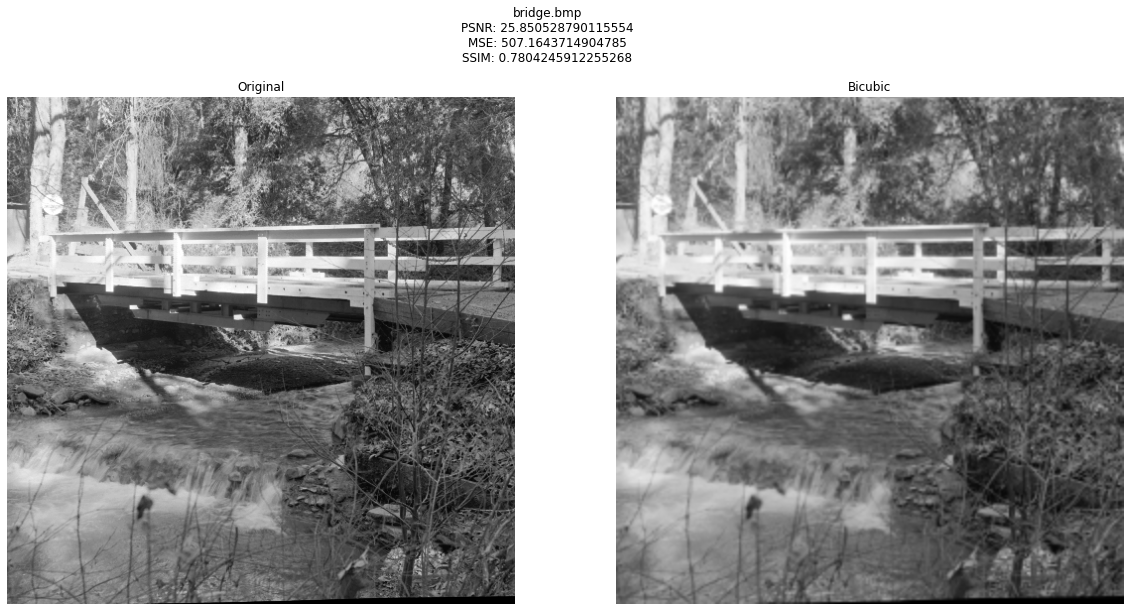

In [79]:
target = cv2.imread('images/bridge.bmp')
ref = cv2.imread('source/bridge.bmp')

# calculate score
scores = compare_images(target, ref)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')

axs[1].imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))
axs[1].set_title('Bicubic')
fig.suptitle('bridge.bmp\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format( scores[0], scores[1], scores[2]))
for ax in axs:
    ax.axis("off")

### Models

In [92]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    SRCNN.summary()
    
    return SRCNN

### Predict

In [93]:
# define necessary image processing functions
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img

def shave(image, border):
    img = image[border: -border, border: -border]
    return img

# define main prediction function
def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('SRCNN_downsample_x2.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_93 (Conv2D)           (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________
Upsampled Image: 
PSNR: 25.948433433645445
MSE: 495.85908220406776
SSIM: 0.7821636014178307

SRCNN Image: 
PSNR: 27.475064066061485
MSE: 348.8953722334004
SSIM: 0.856544776044266



/home/d1guan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


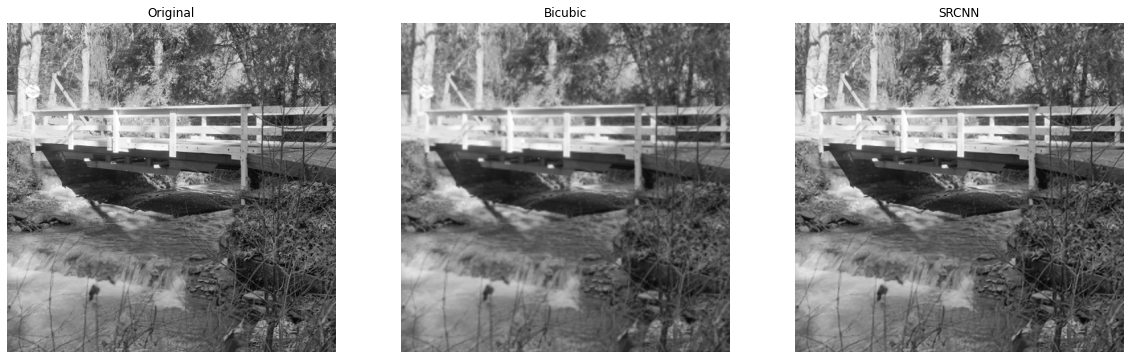

In [94]:
ref, degraded, output, scores = predict('images/bridge.bmp')

# print all scores for all images
print('Upsampled Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('SRCNN Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Bicubic')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.axis("off")

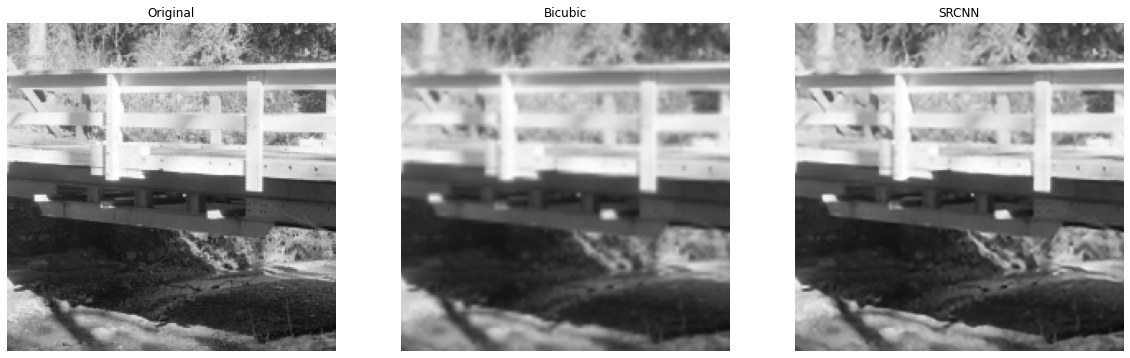

In [95]:
def crop_image(input_img,center,size):
    center_x = center[0]
    center_y = center[1]
    
    crop_img = input_img[int(center_x-size/2):int(center_x+size/2),int(center_y-size/2):int(center_y+size/2),:]
    return crop_img


center = [200,200]
size = 200
ref_crop = crop_image(ref,center,size)
degraded_crop = crop_image(degraded,center,size)
output_crop = crop_image(output, center,size)


fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref_crop, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded_crop, cv2.COLOR_BGR2RGB))
axs[1].set_title('Bicubic')
axs[2].imshow(cv2.cvtColor(output_crop, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.axis("off")

In [13]:
# for file in os.listdir('images'):
    
#     if file != '.ipynb_checkpoints':
    
#         # perform super-resolution
#         ref, degraded, output, scores = predict('images/{}'.format(file))

#         # display images as subplots
#         fig, axs = plt.subplots(1, 3, figsize=(20, 8))
#         axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
#         axs[0].set_title('Original')
#         axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
#         axs[1].set_title('Degraded')
#         axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
#         axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
#         axs[2].set_title('SRCNN')
#         axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

#         # remove the x and y ticks
#         for ax in axs:
#             ax.set_xticks([])
#             ax.set_yticks([])

#         print('Saving {}'.format(file))
#         fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
#         plt.close()